## This notebook makes exploratory plots

After the previous pipeline stages have been run, we have all the ingredients to make a lot of plots:
 - "Galaxies minus randoms" plots, to look for visual systematics.
 - Galaxy auto power spectrum $P_{gg}(k)$
 - Cross power spectrum $P_{gv}(k)$ between galaxies and kSZ velocity reconstruction
 - Auto power spectrum $P_{vv}(k)$ of the kSZ velocity reconstruction

In this notebook, we'll make quick exploratory versions of these plots using **5 Monte Carlo sims**. Because of the small number of sims, some plots will have statistical noise, and we won't put error bars on anything. The next two pipeline stages will address this:
  - `06_run_sims.ipynb`: run 1000 Monte Carlo sims.
  - `07_the_end.ipynb`: re-make plots with 1000 sims.

Another purpose of this notebook is to demonstrate usage of `kszx.KszPSE` (short for "KSZ power spectrum estimator"), a high-level pipeline class for computing $P_{gg}$, $P_{gv}$, and $P_{vv}$. See documentation here: https://kszx.readthedocs.io/en/latest/ksz_pse.html

## Imports and global variables

In [1]:
import kszx
import healpy
import functools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File 'global_params.py' in current directory
import global_params

nkbins = global_params.nkbins
kbin_edges = global_params.kbin_edges
kbin_centers = global_params.kbin_centers

surr_bg = global_params.surr_bg
surr_bv = global_params.surr_bv
surr_fnl = global_params.surr_fnl

In [3]:
# In this exploratory notebook, we'll use 5 mocks and 5 surrogate sims.
nmocks = 5
nsurr = 5

## Read input files
  - `bounding_box.pkl`: created in `04_prepare_catalogs.ipynb`
  - `mock_ngal.npy`: created in `04_prepare_catalogs.ipynb`
  - Lots of SDSS galaxy catalogs

In [4]:
cosmo = kszx.Cosmology('planck18+bao')

box = kszx.io_utils.read_pickle('bounding_box.pkl')
print(box)

Running CAMB
Reading bounding_box.pkl
BoundingBox(
    npix = [320 576 320],
    pixsize = 10.0,
    boxsize = [3200. 5760. 3200.],
    kfund = [0.0019635  0.00109083 0.0019635 ],
    knyq = 0.3141592653589793,
    lpos = [-2963.38860096 -2935.1527411   -475.07298616],
    cpos = [-1368.38860096   -60.1527411   1119.92701384],
    rpos = [ 226.61139904 2814.8472589  2714.92701384]
    rpad = 500.00,
    rmin = 1706.22, rmax = 2579.23,
    npix_prepad = [243 464 257],
    npix_preround = [293 514 307]
)



In [5]:
%%time
gcat = kszx.Catalog.from_h5('catalogs/galaxies.h5')
rcat = kszx.Catalog.from_h5('catalogs/randoms.h5')
mrcat = kszx.Catalog.from_h5('catalogs/mock_randoms.h5')
mcats = [ kszx.Catalog.from_h5(f'catalogs/mock_{i}.h5') for i in range(nmocks) ]
mcat_all = kszx.Catalog.concatenate(mcats)

Reading catalogs/galaxies.h5
Read 568776 galaxies from catalogs/galaxies.h5, columns ['bv_150', 'bv_90', 'cboss', 'dec_deg', 'id', 'ra_deg', 'tcmb_150', 'tcmb_90', 'wcp', 'wfkp', 'wsys', 'wzf', 'z']
Reading catalogs/randoms.h5
CMASS_North randoms: Read 59175065 galaxies from catalogs/randoms.h5, columns ['bv_150', 'bv_90', 'dec_deg', 'ra_deg', 'tcmb_150', 'tcmb_90', 'wfkp', 'z']
Reading catalogs/mock_randoms.h5
CMASS_North qpm mock randoms: Read 64590983 galaxies from catalogs/mock_randoms.h5, columns ['bv_150', 'bv_90', 'dec_deg', 'ra_deg', 'tcmb_150', 'tcmb_90', 'wfkp', 'z']
Reading catalogs/mock_0.h5
mock_galaxy_DR12_CMASS_N_QPM_0001.rdzw: Read 642051 galaxies from catalogs/mock_0.h5, columns ['bv_150', 'bv_90', 'dec_deg', 'ra_deg', 'tcmb_150', 'tcmb_90', 'wfkp', 'wveto', 'z']
Reading catalogs/mock_1.h5
mock_galaxy_DR12_CMASS_N_QPM_0002.rdzw: Read 652204 galaxies from catalogs/mock_1.h5, columns ['bv_150', 'bv_90', 'dec_deg', 'ra_deg', 'tcmb_150', 'tcmb_90', 'wfkp', 'wveto', 'z']
Re

In [6]:
print('Galaxies')
gcat.show()

print('\nRandoms')
rcat.show()

print(f'\nMocks ({nmocks=})')
mcat_all.show()

print('\nMock randoms')
mrcat.show()

Galaxies
Catalog(size=568776, filename=catalogs/galaxies.h5)
    bv_150: min=-514812.6092077757, mean=-208653.6294386937, max=0.0, dtype=float64
    bv_90: min=-309374.7818958487, mean=-123461.41186463524, max=0.0, dtype=float64
    cboss: min=0.3333333432674408, mean=0.988996684551239, max=1.0, dtype=>f4
    dec_deg: min=-3.6193179122860255, mean=28.041107425828713, max=68.73769854149388, dtype=>f8
    id: min=3, mean=630.005450300294, max=3518, dtype=>i4
    ra_deg: min=108.93713069095938, mean=184.8952427499711, max=263.90750667151144, dtype=>f8
    tcmb_150: min=-76262.65587192602, mean=-20.067339677386936, max=69012.92437288744, dtype=float64
    tcmb_90: min=-70675.69112329635, mean=-58.197840340785845, max=271109.88661650993, dtype=float64
    wcp: min=1.0, mean=1.0556968450546265, max=9.0, dtype=>f4
    wfkp: min=0.1892767697572708, mean=0.27865079045295715, max=0.691905677318573, dtype=>f4
    wsys: min=0.7824344038963318, mean=0.9942048788070679, max=1.628982663154602, dtype=

Reading mock_ngal.npy
ngal_mean=651315.655, ngal_rms=3344.8465573139524 [4.14457918065729 times Poisson]


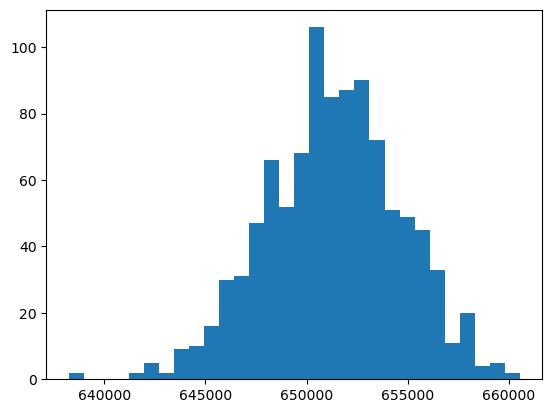

In [7]:
mock_ngal = kszx.io_utils.read_npy('mock_ngal.npy')
ngal_mean = np.mean(mock_ngal)
ngal_rms = np.var(mock_ngal)**0.5

print(f'{ngal_mean=}, {ngal_rms=} [{ngal_rms/np.sqrt(ngal_mean)} times Poisson]')

plt.hist(mock_ngal, bins=30)
plt.show()

## Visual inspection of maps, part 1: galaxies and randoms

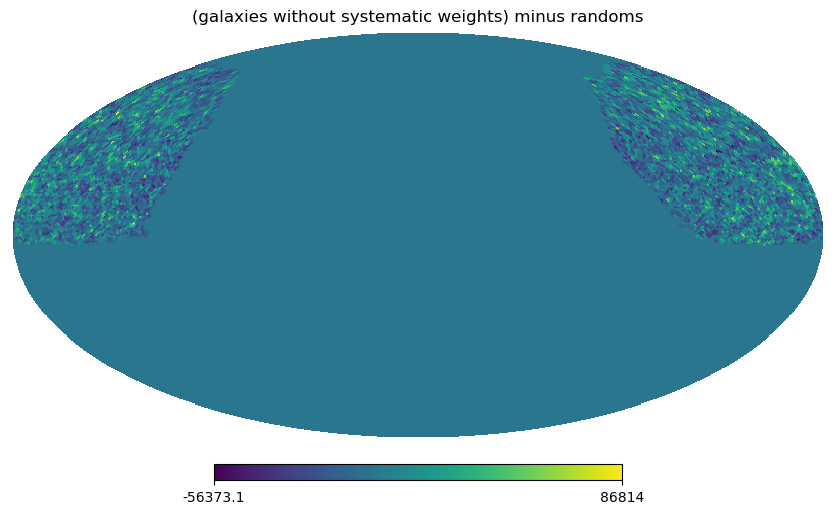

In [8]:
gals_nosys_minus_randoms = kszx.healpix_utils.map_from_catalog(64, gcat, weights=gcat.wfkp, rcat=rcat, rweights=rcat.wfkp)
healpy.mollview(gals_nosys_minus_randoms, title='(galaxies without systematic weights) minus randoms')

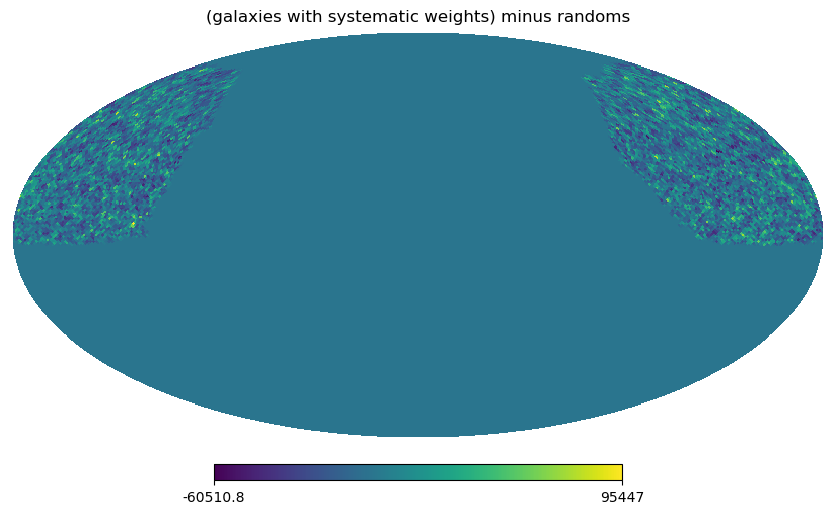

In [9]:
wsys = (gcat.wzf + gcat.wcp - 1) * gcat.wsys
gals_wsys_minus_randoms = kszx.healpix_utils.map_from_catalog(64, gcat, weights=gcat.wfkp*wsys, rcat=rcat, rweights=rcat.wfkp)
healpy.mollview(gals_wsys_minus_randoms, title='(galaxies with systematic weights) minus randoms')

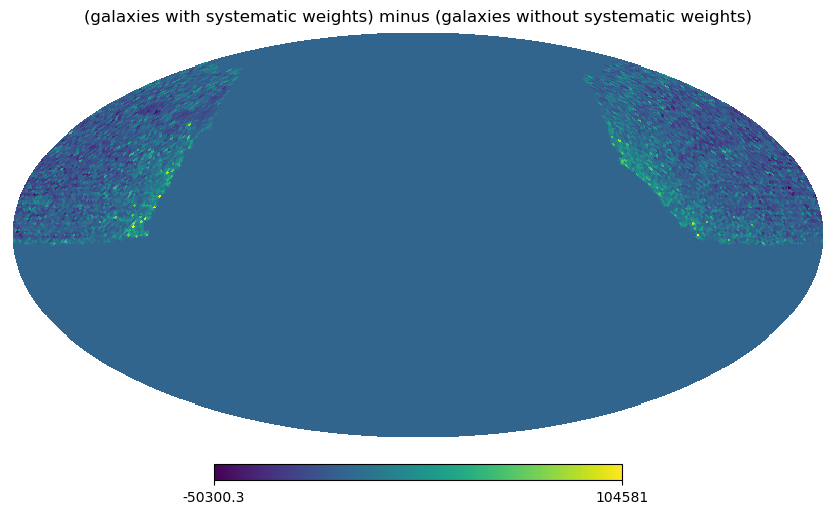

In [10]:
gals_wsys_minus_gals_nosys = kszx.healpix_utils.map_from_catalog(64, gcat, weights=wsys, rcat=gcat)

healpy.mollview(
    gals_wsys_minus_gals_nosys, 
    title='(galaxies with systematic weights) minus (galaxies without systematic weights)'
)

## Visual inspection of maps, part 2: kSZ velocity reconstruction

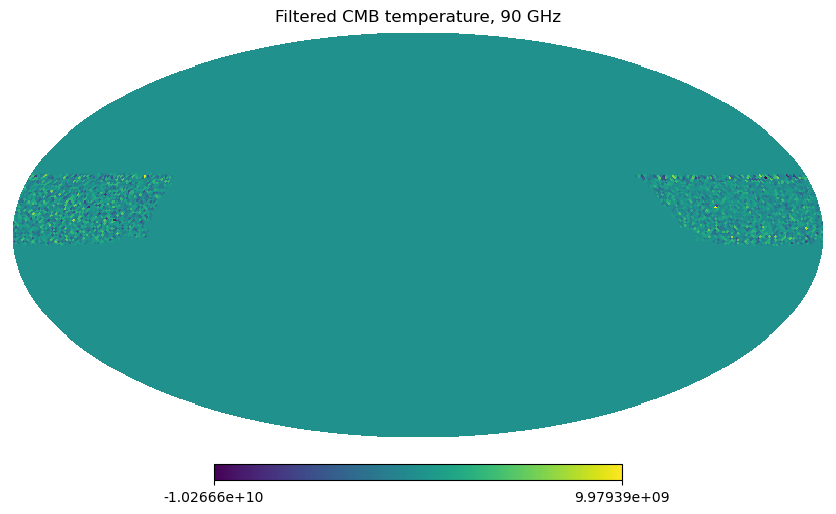

In [11]:
healpix_tcmb_90 = kszx.healpix_utils.map_from_catalog(64, rcat, weights=rcat.tcmb_90)
healpy.mollview(healpix_tcmb_90, title='Filtered CMB temperature, 90 GHz')

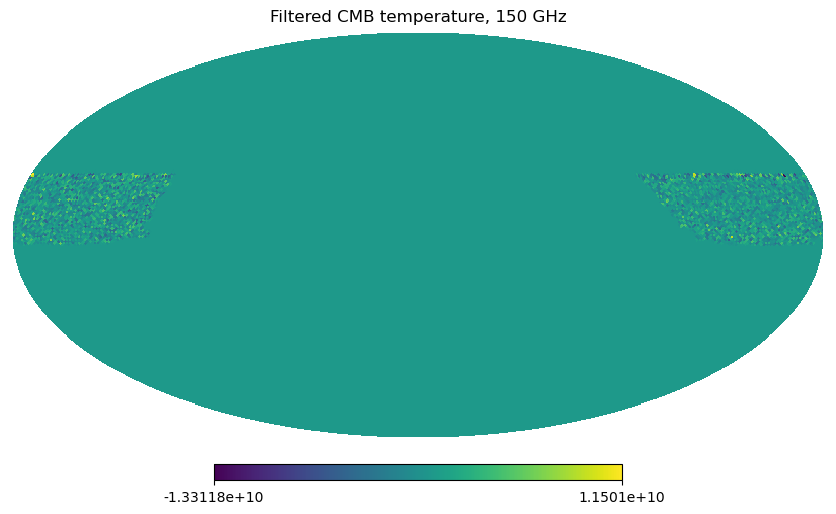

In [12]:
healpix_tcmb_150 = kszx.healpix_utils.map_from_catalog(64, rcat, weights=rcat.tcmb_150)
healpy.mollview(healpix_tcmb_150, title='Filtered CMB temperature, 150 GHz')

## Visual inspection of maps, part 3: mocks and mock randoms

My conclusions in this part:

 - Mock randoms differ significantly from randoms
 - It looks consistent (at least visually) to use (mocks with no veto mask) + (mock random catalog).
 - It also looks consistent (at least visually) to use (mocks with veto mask) + (random catalog).
 - Other combinations are not consistent.

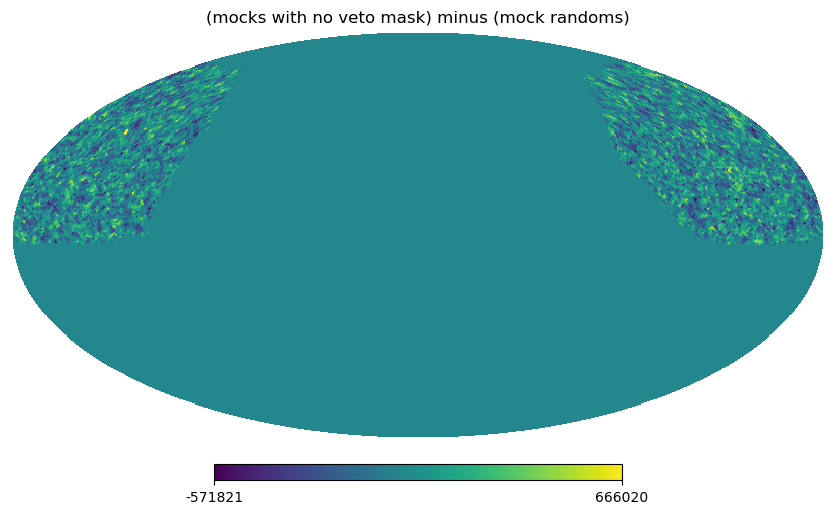

In [13]:
mocks_noveto_minus_mock_randoms = kszx.healpix_utils.map_from_catalog(64, mcat_all, rcat=mrcat)
healpy.mollview(mocks_noveto_minus_mock_randoms, title='(mocks with no veto mask) minus (mock randoms)')

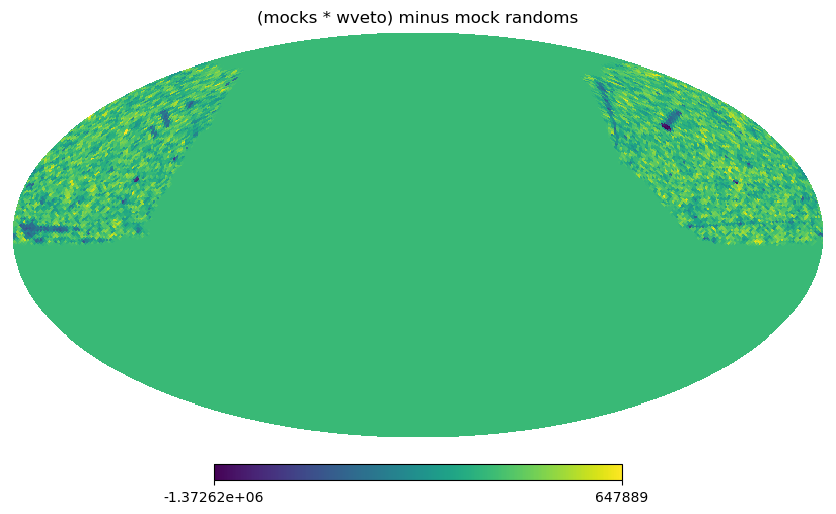

In [14]:
mocks_wveto_minus_mock_randoms = kszx.healpix_utils.map_from_catalog(64, mcat_all, weights=mcat_all.wveto, rcat=mrcat)
healpy.mollview(mocks_wveto_minus_mock_randoms, title='(mocks * wveto) minus mock randoms')

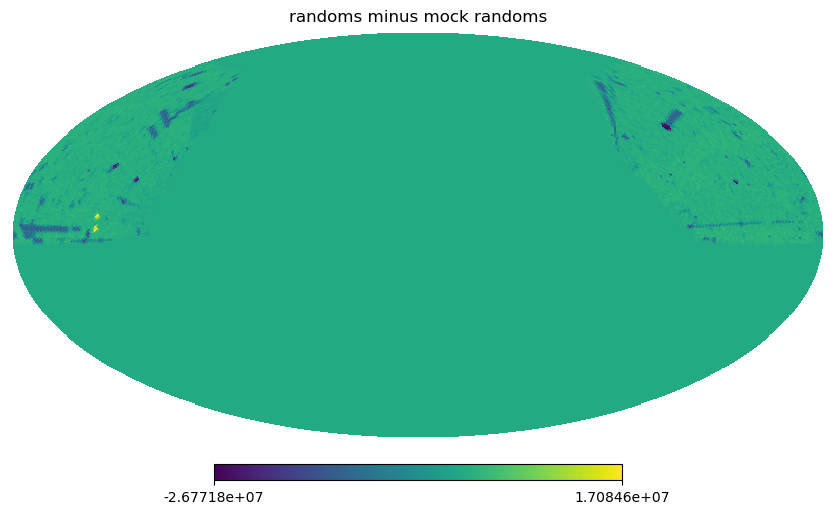

In [15]:
randoms_minus_mock_randoms = kszx.healpix_utils.map_from_catalog(64, rcat, rcat=mrcat)
healpy.mollview(randoms_minus_mock_randoms, title='randoms minus mock randoms')

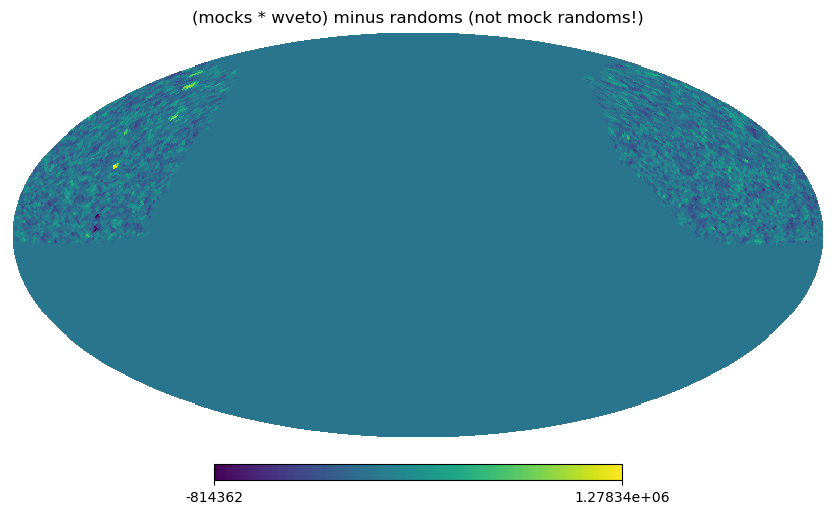

In [16]:
mocks_wveto_minus_randoms = kszx.healpix_utils.map_from_catalog(64, mcat_all, weights=mcat_all.wveto, rcat=rcat)
healpy.mollview(mocks_wveto_minus_randoms, title='(mocks * wveto) minus randoms (not mock randoms!)')

## Setting up power spectrum estimation

In [17]:
@functools.cache
def get_pse(mrand):
    """Returns a kszx.KszPSE object.

    A KszPSE computes power spectra involving a galaxy field and one or more velocity
    reconstructions, or surrogates for these fields. In our pipeline, we use two velocity
    reconstructions vr_90, vr_150 (corresponding to 90+150 GHz CMB data). See the KszPSE
    docstring for more info.
    
    If 'mrand' is True, use the mock random catalog, instead of the random catalog.
    (The KszPSE constructor needs the random catalog to define the survey geometry.)
    """

    print(f'Constructing PSE ({mrand=})\n', end='')
    
    rname = 'mock_randoms.h5' if mrand else 'randoms.h5'
    catalog = kszx.Catalog.from_h5(f'catalogs/{rname}')
    
    return kszx.KszPSE(
        box = box, 
        cosmo = cosmo, 
        randcat = catalog, 
        kbin_edges = kbin_edges,
        surr_ngal_mean = ngal_mean,   # ngal_mean was computed above
        surr_ngal_rms = ngal_rms,     # ngal_rms was computed above
        surr_bg = surr_bg,
        rweights = catalog.wfkp,
        nksz = 2,
        # ksz_rweights = None,
        ksz_bv = [ catalog.bv_90, catalog.bv_150 ],
        ksz_tcmb_realization = [ catalog.tcmb_90, catalog.tcmb_150 ]
    )

In [18]:
def project_tcmb(bv, tcmb):
    """The arguments are 1-d arrays of (bv, tcmb) values, evaluated at galaxy locations.
    Returns a new tcmb array, after subtracting the bv-weighted mean.
    Added by KMS 2025 April 22."""
    return tcmb - (np.dot(bv,tcmb)/np.dot(bv,bv)) * bv

In [19]:
def run_data(sysweights):
    """Compute P_gg, P_gv, and P_vv for SDSS data. If 'sysweights' is true, include (wzf+wcp-1) * wsys).

    The result is returned as a shape (nfields, nfields, nkbins) array, where the field index
    has length nfields=3, and indexes a field { gal, vr_90, vr_150 }. Thus, the returned array
    contains all auto and cross power spectra involving the galaxy field and velocity reconstructions.
    """

    gweights = (gcat.wfkp * (gcat.wzf + gcat.wcp - 1) * gcat.wsys) if sysweights else gcat.wfkp
    pse = get_pse(False)

    # Mean subtraction (added by KMS 2025 April 22)
    t90 = project_tcmb(gcat.bv_90, gcat.tcmb_90)
    t150 = project_tcmb(gcat.bv_150, gcat.tcmb_150)

    pk = pse.eval_pk(
        gcat = gcat,
        gweights = gweights,
        # ksz_gweights = None, 
        ksz_bv = [ gcat.bv_90, gcat.bv_150 ], 
        ksz_tcmb = [ t90, t150 ]
    )

    return pk

In [20]:
def run_mock(i):
    """Compute P_gg, P_gv, and P_vv for one SDSS mock.

    The result is returned as a shape (nfields, nfields, nkbins) array, where the field index
    has length nfields=3, and indexes a field { gal, vr_90, vr_150 }. Thus, the returned array
    contains all auto and cross power spectra involving the galaxy field and velocity reconstructions.
    """
    
    mcat = mcats[i]
    pse = get_pse(True)
    
    # Mean subtraction (added by KMS 2025 April 22)
    t90 = project_tcmb(mcat.bv_90, mcat.tcmb_90)
    t150 = project_tcmb(mcat.bv_150, mcat.tcmb_150)
    
    pk = pse.eval_pk(
        gcat = mcat,
        gweights = mcat.wfkp,  # no sysweights for mocks
        # ksz_gweights = None, 
        ksz_bv = [ mcat.bv_90, mcat.bv_150 ], 
        ksz_tcmb = [ t90, t150 ]
    )
    
    return pk

In [21]:
def run_surrogate(i):
    """Compute P_gg, P_gv, and P_vv for one SDSS surrogate.

    The result is returned as a shape (nfields, nfields, nkbins) array, where the
    field index has length nfields=6, and indexes a field 
       { gal, dgal/dfNL, vr90, d(vr90)/dbv, vr150, d(vr150)/dbv }. 
    
    Thus, the returned array contains all auto and cross power spectra involving the
    surrogate galaxy field and velocity reconstructions, for all fNL and b_v values.
    """

    pse = get_pse(False)
    pse.simulate_surrogate()
    
    # Mean subtraction (added by KMS 2025 April 22)
    # Reminder: the pse.Sv_* arrays have shape (nksz, nrand), where nksz=2 corresponds to [90,150],
    # and includes the small-scale weighting W_S.
    
    pse.Sv_noise -= np.mean(pse.Sv_noise, axis=1).reshape((-1,1))
    pse.Sv_signal -= np.mean(pse.Sv_signal, axis=1).reshape((-1,1))

    pk = pse.eval_pk_surrogate()    
    return pk

## Evaluate power spectrum estimators

  - We use a multiprocessing Pool to run 12 realizations in parallel (5 mocks, 5 surrogates, data with sysweights, data without sysweights).

  - **IMPORTANT NOTE**: we construct the power spectrum estimators before creating the multiprocessing Pool. This is okay because the estimators are the same for all workers in the pool. If instead of doing this, we constructed a power spectrum estimator independently on each worker, the memory usage would be much higher!

  - **IMPORANT NOTE**: we use a kszx.utils.Pool, not a multiprocessing.Pool. This reseeds the global numpy RNG in each worker process. If we didn't do this, all five surrogate simulations would be identical! See the [kszx.utils.Pool](https://kszx.readthedocs.io/en/latest/misc_utils.html#kszx.utils.Pool) docstring for more discussion.

In [22]:
# IMPORTANT NOTE: we construct the power spectrum estimators before creating the multiprocessing Pool.
# This is okay because the estimators are the same for all workers in the pool.

# If instead of doing this, we constructed a power spectrum estimator independently on each worker, the
# memory usage would be much higher!

get_pse(True)
get_pse(False)

Constructing PSE (mrand=True)
Reading catalogs/mock_randoms.h5
CMASS_North qpm mock randoms: Read 64590983 galaxies from catalogs/mock_randoms.h5, columns ['bv_150', 'bv_90', 'dec_deg', 'ra_deg', 'tcmb_150', 'tcmb_90', 'wfkp', 'z']
Constructing PSE (mrand=False)
Reading catalogs/randoms.h5
CMASS_North randoms: Read 59175065 galaxies from catalogs/randoms.h5, columns ['bv_150', 'bv_90', 'dec_deg', 'ra_deg', 'tcmb_150', 'tcmb_90', 'wfkp', 'z']


In [23]:
%%time

# IMPORTANT NOTE: we use a kszx.utils.Pool, not a multiprocessing.Pool.
# This reseeds the global numpy RNG in each worker process.
# If we didn't do this, all five surrogate simulations would be identical!

with kszx.utils.Pool() as pool:
    # Submit jobs to queue, return multiprocessing.AsyncResult objects.
    pk_data_nosys = pool.apply_async(run_data, (False,))
    pk_data_wsys = pool.apply_async(run_data, (True,))
    pk_surr = [ pool.apply_async(run_surrogate, (i,)) for i in range(nsurr) ]
    pk_mocks = [ pool.apply_async(run_mock, (i,)) for i in range(nmocks) ]

    # Wait on results and convert to numpy arrays.
    pk_data_nosys = pk_data_nosys.get()                 # shape (3, 3, nkbins)
    pk_data_wsys = pk_data_wsys.get()                   # shape (3, 3, nkbins)
    pk_surr = np.array([ x.get() for x in pk_surr ])    # shape (nsurr, 6, 6, nkbins)
    pk_mocks = np.array([ x.get() for x in pk_mocks ])  # shape (nmocks, 3, 3, nkbins)

Creating multiprocessing pool with 32 worker processes, and 2 threads/worker.
Global numpy RNG will be re-seeded in each worker process.
CPU times: user 0 ns, sys: 6.22 s, total: 6.22 s
Wall time: 3min 30s


## Helper functions for postprocessing surrogates

In [26]:
# Some paranoid checks
assert pk_data_nosys.shape == (3,3,nkbins)
assert pk_data_wsys.shape == (3,3,nkbins)
assert pk_surr.shape == (nsurr,6,6,nkbins)
assert pk_mocks.shape == (nmocks,3,3,nkbins)

In [27]:
def specialize_surrogates(fnl, bv):
    """
    As noted above, the 'pk_surr' array has shape (nsurr,6,6,nkbins), where the 
    length-6 axes are { gal, dgal/dfNL, vr90, d(vr90)/dbv, vr150, d(vr150)/dbv }. 
    This allows all values of (fNL, bv) to be available in postprocessing.

    This function "specializes" the surrogate power spectra to a specific value
    of (fnl,bv), and returns an array of shape (nsurr, 3, 3, nkbins), where the
    length-3 axis is {gal,vr90,vr150}.
    """

    # Currently assuming same bv for 90 and 150 GHz.
    w = np.array([ fnl, bv, bv ])
    
    # Reshape (nsurr,6,6,nkbins) -> (nsurr,3,2,3,2,nkbins).    
    pk = np.reshape(pk_surr, (nsurr,3,2,3,2,nkbins))

    # Specialize first axis, obtaining shape (nsurr,3,3,2,nkbins).
    pk = pk[:,:,0,:,:,:] + w.reshape((1,3,1,1,1)) * pk[:,:,1,:,:,:]

    # Specialize second axis, obtaining shape (nsurr,3,3,nkbins).
    pk = pk[:,:,:,0,:] + w.reshape((1,1,3,1)) * pk[:,:,:,1,:]
    return pk

In [45]:
# Shape (nsurr,3,3,nkbins) arrays, containing surrogate power spectra,
# specialized to a few choices of (fnl,bv).

pk_surr_fnl0 = specialize_surrogates(fnl=0,bv=surr_bv)
pk_surr_fnlpos = specialize_surrogates(fnl=surr_fnl,bv=surr_bv)
pk_surr_fnlneg = specialize_surrogates(fnl=-surr_fnl,bv=surr_bv)

## Power spectra, part 1: P_gg


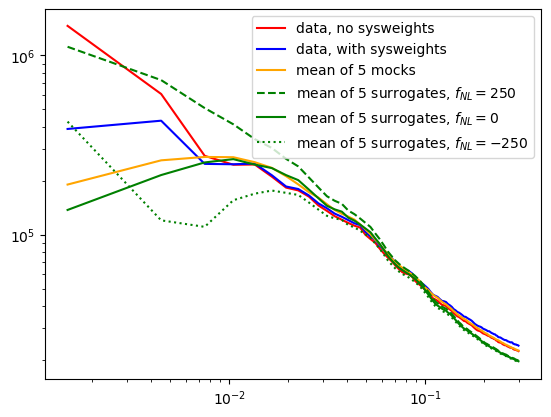

In [35]:
plt.plot(kbin_centers, pk_data_nosys[0,0,:], label='data, no sysweights', color='red')
plt.plot(kbin_centers, pk_data_wsys[0,0,:], label='data, with sysweights', color='blue')
plt.plot(kbin_centers, np.mean(pk_mocks[:,0,0,:],axis=0), label=f'mean of {nmocks} mocks', color='orange')
plt.plot(kbin_centers, np.mean(pk_surr_fnlpos[:,0,0,:],axis=0), label=f'mean of {nsurr} surrogates, $f_{{NL}}={surr_fnl}$', color='green', ls='--')
plt.plot(kbin_centers, np.mean(pk_surr_fnl0[:,0,0,:],axis=0), label=f'mean of {nsurr} surrogates, $f_{{NL}}=0$', color='green', ls='-')
plt.plot(kbin_centers, np.mean(pk_surr_fnlneg[:,0,0,:],axis=0), label=f'mean of {nsurr} surrogates, $f_{{NL}}={-surr_fnl}$', color='green', ls=':')
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Power spectra part 2: P_gv

 - We show $P_{gv}$ for surrogates, but not for mocks. This is because the velocity reconstruction of the mock catalogs is pure reconstruction noise (it's obtained by using real ACT data and mock SDSS data, which is one reasonable way of simulating the reconstruction noise, but doesn't contain a simulated velocity field).

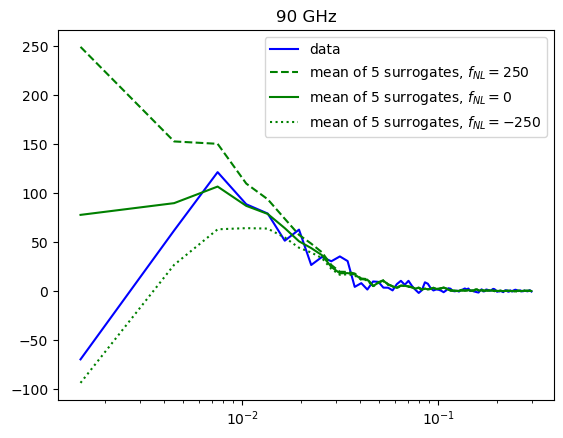

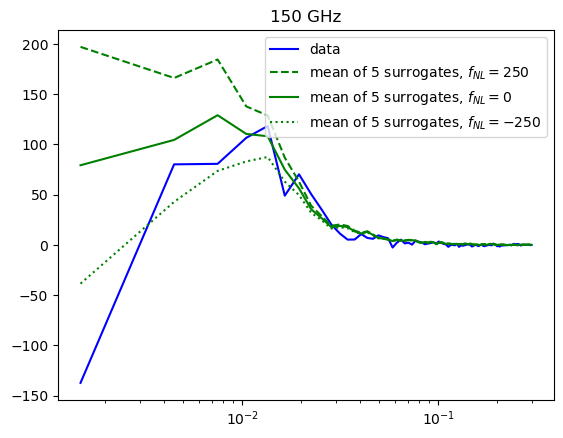

In [46]:
pgv_data = pk_data_wsys[0,1:,:]                             # shape (2,nkbins), first axis is [90,150] GHz
pgv_mocks = np.mean(pk_mocks[:,0,1:,:], axis=0)             # shape (2,nkbins), first axis is [90,150] GHz
pgv_surr_fnl0 = np.mean(pk_surr_fnl0[:,0,1:,:], axis=0)     # shape (2,nkbins), first axis is [90,150] GHz
pgv_surr_fnlp = np.mean(pk_surr_fnlpos[:,0,1:,:], axis=0)   # shape (2,nkbins), first axis is [90,150] GHz
pgv_surr_fnln = np.mean(pk_surr_fnlneg[:,0,1:,:], axis=0)   # shape (2,nkbins), first axis is [90,150] GHz

def plot_pgv(ifreq, title):
    plt.plot(kbin_centers, pgv_data[ifreq], label='data', color='blue')
    
    plt.plot(kbin_centers, pgv_surr_fnlp[ifreq,:], label=f'mean of {nsurr} surrogates, $f_{{NL}}={surr_fnl}$', color='green', ls='--')
    plt.plot(kbin_centers, pgv_surr_fnl0[ifreq,:], label=f'mean of {nsurr} surrogates, $f_{{NL}}=0$', color='green', ls='-')
    plt.plot(kbin_centers, pgv_surr_fnln[ifreq,:], label=f'mean of {nsurr} surrogates, $f_{{NL}}={-surr_fnl}$', color='green', ls=':')
    
    # Uncomment to show mocks (should be consistent with zero, see bullet point above)
    # plt.plot(kbin_centers, pgv_mocks[ifreq], label='mocks', color='orange')
    
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xscale('log')
    plt.show()

plot_pgv(0, '90 GHz')
plot_pgv(1, '150 GHz')

## Power spectra part 3: P_vv
 - Recall that we have two velocity reconstructions, denoted $v_r^{90}$ and $v_r^{150}$, made from 90 GHz and 150 GHz CMB data.
 - We plot the auto power spectrum of the $v_r^{90}$ and $v_r^{150}$ maps, and also the $(v_r^{90} \times v_r^{150})$ cross power.
 - We show $P_{vv}$ for surrogates, but not for mocks. This is because the velocity reconstruction of the mock catalogs is pure reconstruction noise (it's obtained by using real ACT data and mock SDSS data, which is one reasonable way of simulating the reconstruction noise, but doesn't contain a simulated velocity field).
 - The 90 GHz reconstruction has a lot of large scale power, and the The $(v_r^{90} \times v_r^{150})$ map also has a moderate level of large scale power. This is consistent with the large-scale power being due to foregrounds. (I haven't experimented with any ideas for removing foregrounds in the velocity reconstruction.)
 - On small scales, the data has a little more power than the surrogates -- not sure how to interpret that!

In [49]:
pvv_data = pk_data_wsys[1:,1:,:]                     # shape (2,2,nkbins), length-2 axes are [v90,v150]
pvv_mocks = np.mean(pk_mocks[:,1:,1:,:], axis=0)     # shape (2,2,nkbins), length-2 axes are [v90,v150]
pvv_surr = np.mean(pk_surr_fnl0[:,1:,1:,:], axis=0)  # shape (2,2,nkbins), length-2 axes are [v90,v150]

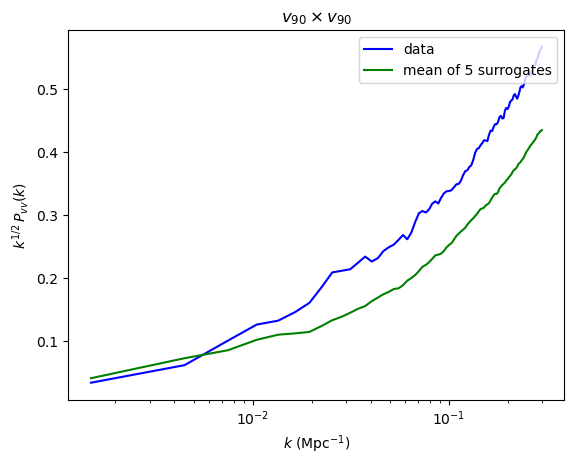

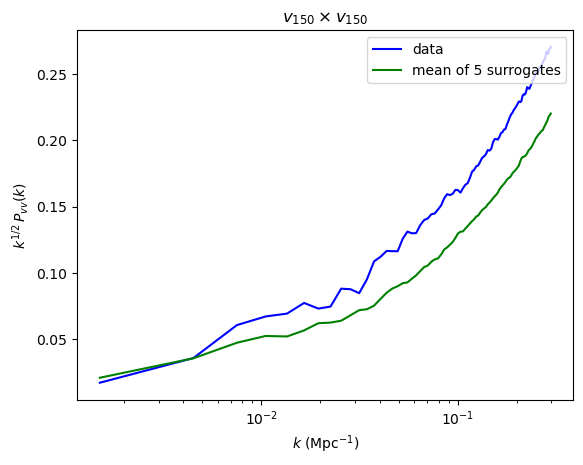

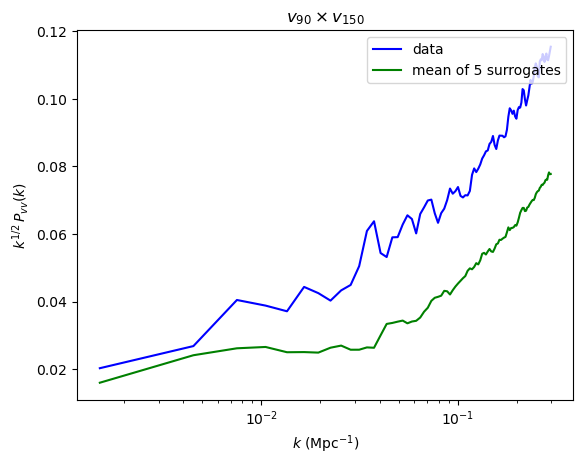

In [50]:
def plot_pvv(ifreq1, ifreq2, title):
    t = kbin_centers**0.5
    plt.plot(kbin_centers, t * pvv_data[ifreq1,ifreq2], label='data', color='blue')
    plt.plot(kbin_centers, t * pvv_surr[ifreq1,ifreq2,:], label = f'mean of {nsurr} surrogates', color='green', ls='-',)
    
    # Uncomment to show mocks (should be another estimate of reconstruction noise, see above)
    # plt.plot(kbin_centers, t*pvv_mocks[ifreq1,ifreq2,:], label='mocks', color='orange')
    
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)')
    plt.ylabel(r'$k^{1/2} \, P_{vv}(k)$')
    plt.xscale('log')
    plt.show()

plot_pvv(0, 0, r'$v_{90} \times v_{90}$')
plot_pvv(1, 1, r'$v_{150} \times v_{150}$')
plot_pvv(0, 1, r'$v_{90} \times v_{150}$')